In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import pandas as pd
import datetime
from physoce import tseries
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cigmt
from maptools import load_crm_asc
from maptools import make_map
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison

In [2]:
file = 'sf_os_46026.txt'
file1 = 'sf_ns_PRYC1.txt'
file2 = 'bb_os_46013.txt'
file3 = 'bb_ns_BDXC1.txt'
sfos = pd.read_csv(file,skiprows=1,na_values=[99.00,999,999.0],delim_whitespace=True,engine='python')
sfns = pd.read_csv(file1,skiprows=1,na_values=[99.00,99,999,999.0],delim_whitespace=True,engine='python')
bbos = pd.read_csv(file2,skiprows=1,na_values=[99,999,999.0],delim_whitespace=True,engine='python')
bbns = pd.read_csv(file3,skiprows=1,na_values=[99,999,999.0],delim_whitespace=True,engine='python')


In [3]:
print(sfos.keys())
print(sfns.keys())
print(bbos.keys())
print(bbns.keys())

Index(['yr', 'mo', 'dy', 'hr', 'mn', 'degT', 'm/s', 'm/s.1', 'm', 'sec',
       'sec.1', 'degT.1', 'hPa', 'degC', 'wtmp', 'degC.1', 'mi', 'ft'],
      dtype='object')
Index(['yr', 'mo', 'dy', 'hr', 'mn', 'degT', 'm/s', 'm/s.1', 'm', 'sec',
       'sec.1', 'degT.1', 'hPa', 'ATMP', 'wtmp', 'DEWP', 'mi', 'ft'],
      dtype='object')
Index(['yr', 'mo', 'dy', 'hr', 'mn', 'degT', 'm/s', 'm/s.1', 'm', 'sec',
       'sec.1', 'degT.1', 'hPa', 'degC', 'degC.1', 'degC.2', 'mi', 'ft'],
      dtype='object')
Index(['yr', 'mo', 'dy', 'hr', 'mn', 'm', 'degC', 'mS/cm', 'psu', 'ppm',
       'ug/l', 'FTU', '-', 'mv'],
      dtype='object')


In [4]:
#qa/qc
ii = np.isfinite(sfos.wtmp) + sfos.wtmp<99 
kk = np.isfinite(sfns.wtmp) + sfns.wtmp<99
jj = np.isfinite(bbns.degC) + bbns.degC<99
nn = np.isfinite(bbos['degC.1']) + bbos['degC.1']<99

In [5]:
GoF = [-123.5,-121.8,37.4,38.5]

In [6]:
#date string
time_sfos = pd.to_datetime(dict(year=sfos.yr,month=sfos.mo,day=sfos.dy,hour=sfos.hr,minute=sfos.mn))
time_sfns = pd.to_datetime(dict(year=sfns.yr,month=sfns.mo,day=sfns.dy,hour=sfns.hr,minute=sfns.mn))
time_bbos = pd.to_datetime(dict(year=bbos.yr,month=bbos.mo,day=bbos.dy,hour=bbos.hr,minute=bbos.mn))
time_bbns = pd.to_datetime(dict(year=bbns.index, month=bbns.yr, day=bbns.mo, hour=bbns.hr, minute=bbns.mn))

In [8]:
#temp vectors
temp_sfos = sfos.wtmp[ii]
temp_sfns = sfns.wtmp[kk]
temp_bbos = bbos['degC.1'][nn]
temp_bbns = bbns.m[jj]

In [9]:
#time vectors
sfns['time'] = time_sfns
sfns = sfns.set_index('time')
sfos['time'] = time_sfos
sfos = sfos.set_index('time')
bbos['time'] = time_bbos
bbos = bbos.set_index('time')
bbns['time'] = time_bbns
bbns = bbns.set_index('time')

In [10]:
sfns.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:06:00',
               '2017-01-01 00:12:00', '2017-01-01 00:18:00',
               '2017-01-01 00:24:00', '2017-01-01 00:30:00',
               '2017-01-01 00:36:00', '2017-01-01 00:42:00',
               '2017-01-01 00:48:00', '2017-01-01 00:54:00',
               ...
               '2017-12-31 23:00:00', '2017-12-31 23:06:00',
               '2017-12-31 23:12:00', '2017-12-31 23:18:00',
               '2017-12-31 23:24:00', '2017-12-31 23:30:00',
               '2017-12-31 23:36:00', '2017-12-31 23:42:00',
               '2017-12-31 23:48:00', '2017-12-31 23:54:00'],
              dtype='datetime64[ns]', name='time', length=82916, freq=None)

In [11]:
#reshaping to an hourly sample for all station
sfns_hrly = sfns.resample('1H').mean()
sfos_hrly = sfos.resample('1H').mean()
bbos_hrly = bbos.resample('1H').mean()
bbns_hrly = bbns.resample('1H').mean()

In [12]:
sfns_hrly

,yr,mo,dy,hr,mn,degT,m/s,m/s.1,m,sec,sec.1,degT.1,hPa,ATMP,wtmp,DEWP,mi,ft
time,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017.0,1.0,1.0,0.0,27.0,280.800000,3.36,4.31,NaN,NaN,NaN,NaN,1912.54,10.12,10.60,NaN,NaN,NaN
2017-01-01 01:00:00,2017.0,1.0,1.0,1.0,27.0,277.500000,4.05,5.14,NaN,NaN,NaN,NaN,1912.64,9.75,10.58,NaN,NaN,NaN
2017-01-01 02:00:00,2017.0,1.0,1.0,2.0,27.0,278.400000,4.95,6.65,NaN,NaN,NaN,NaN,1014.07,10.25,10.50,NaN,NaN,NaN
2017-01-01 03:00:00,2017.0,1.0,1.0,3.0,27.0,258.200000,2.11,3.45,NaN,NaN,NaN,NaN,1014.10,10.31,10.50,NaN,NaN,NaN
2017-01-01 04:00:00,2017.0,1.0,1.0,4.0,27.0,286.900000,4.93,6.71,NaN,NaN,NaN,NaN,1014.27,11.11,10.44,NaN,NaN,NaN
2017-01-01 05:00:00,2017.0,1.0,1.0,5.0,27.0,285.500000,5.76,7.86,NaN,NaN,NaN,NaN,1014.14,10.80,10.40,NaN,NaN,NaN
2017-01-01 06:00:00,2017.0,1.0,1.0,6.0,27.0,286.000000,6.45,8.40,NaN,NaN,NaN,NaN,1014.25,10.57,10.38,NaN,NaN,NaN
2017-01-01 07:00:00,2017.0,1.0,1.0,7.0,27.0,285.900000,7.83,9.95,NaN,NaN,NaN,NaN,1014.38,10.70,10.30,NaN,NaN,NaN
2017-01-01 08:00:00,2017.0,1.0,1.0,8.0,27.0,288.800000,9.82,12.21,NaN,NaN,NaN,NaN,1014.22,10.78,10.22,NaN,NaN,NaN


In [13]:
print(sfns_hrly.keys())
print(sfos_hrly.keys())
print(bbns_hrly.keys())
print(bbos_hrly.keys())

Index(['yr', 'mo', 'dy', 'hr', 'mn', 'degT', 'm/s', 'm/s.1', 'm', 'sec',
       'sec.1', 'degT.1', 'hPa', 'ATMP', 'wtmp', 'DEWP', 'mi', 'ft'],
      dtype='object')
Index(['yr', 'mo', 'dy', 'hr', 'mn', 'degT', 'm/s', 'm/s.1', 'm', 'sec',
       'sec.1', 'degT.1', 'hPa', 'degC', 'wtmp', 'degC.1', 'mi', 'ft'],
      dtype='object')
Index(['yr', 'mo', 'dy', 'hr', 'mn', 'm', 'degC', 'mS/cm', 'psu', 'ppm',
       'ug/l', 'FTU', '-', 'mv'],
      dtype='object')
Index(['yr', 'mo', 'dy', 'hr', 'mn', 'degT', 'm/s', 'm/s.1', 'm', 'sec',
       'sec.1', 'degT.1', 'hPa', 'degC', 'degC.1', 'degC.2', 'mi', 'ft'],
      dtype='object')


In [24]:
sfns_tmp = sfns_hrly.wtmp.interpolate(method='linear',limit=6)
sfos_tmp = sfos_hrly.wtmp.interpolate(method='linear',limit=6)
bbos_tmp = bbos_hrly['degC.1'].interpolate(method='linear',limit=6)
bbns_tmp = bbns.m.interpolate(method='linear',limit=6)

In [25]:
sfos_lfp = tseries.pl66(sfos_tmp)
sfns_lfp = tseries.pl66(sfns_tmp)
bbos_lfp = tseries.pl66(bbos_tmp)
bbns_lfp = tseries.pl66(bbns_tmp)

In [26]:
#plt.plot(bbns_hrly.index,bbns_lfp)

<IPython.core.display.Javascript object>


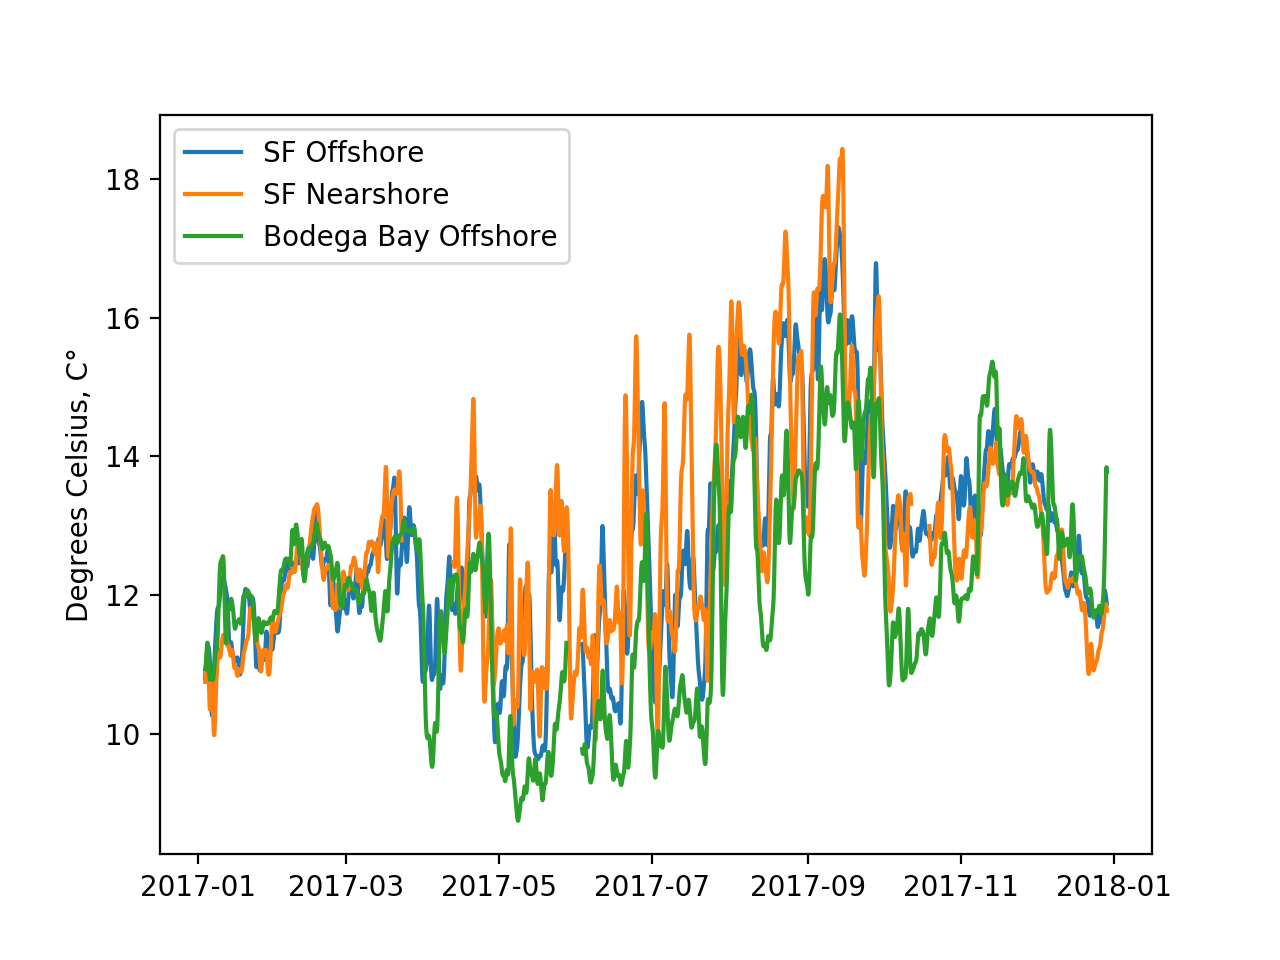

In [27]:
plt.figure()
plt.plot(sfos_hrly.index,sfos_lfp)
plt.plot(sfns_hrly.index,sfns_lfp)
plt.plot(bbos_hrly.index,bbos_lfp)
plt.ylabel('Degrees Celsius, C°')
stations = ['SF Offshore', 'SF Nearshore', 'Bodega Bay Offshore']
plt.legend(stations)

<IPython.core.display.Javascript object>


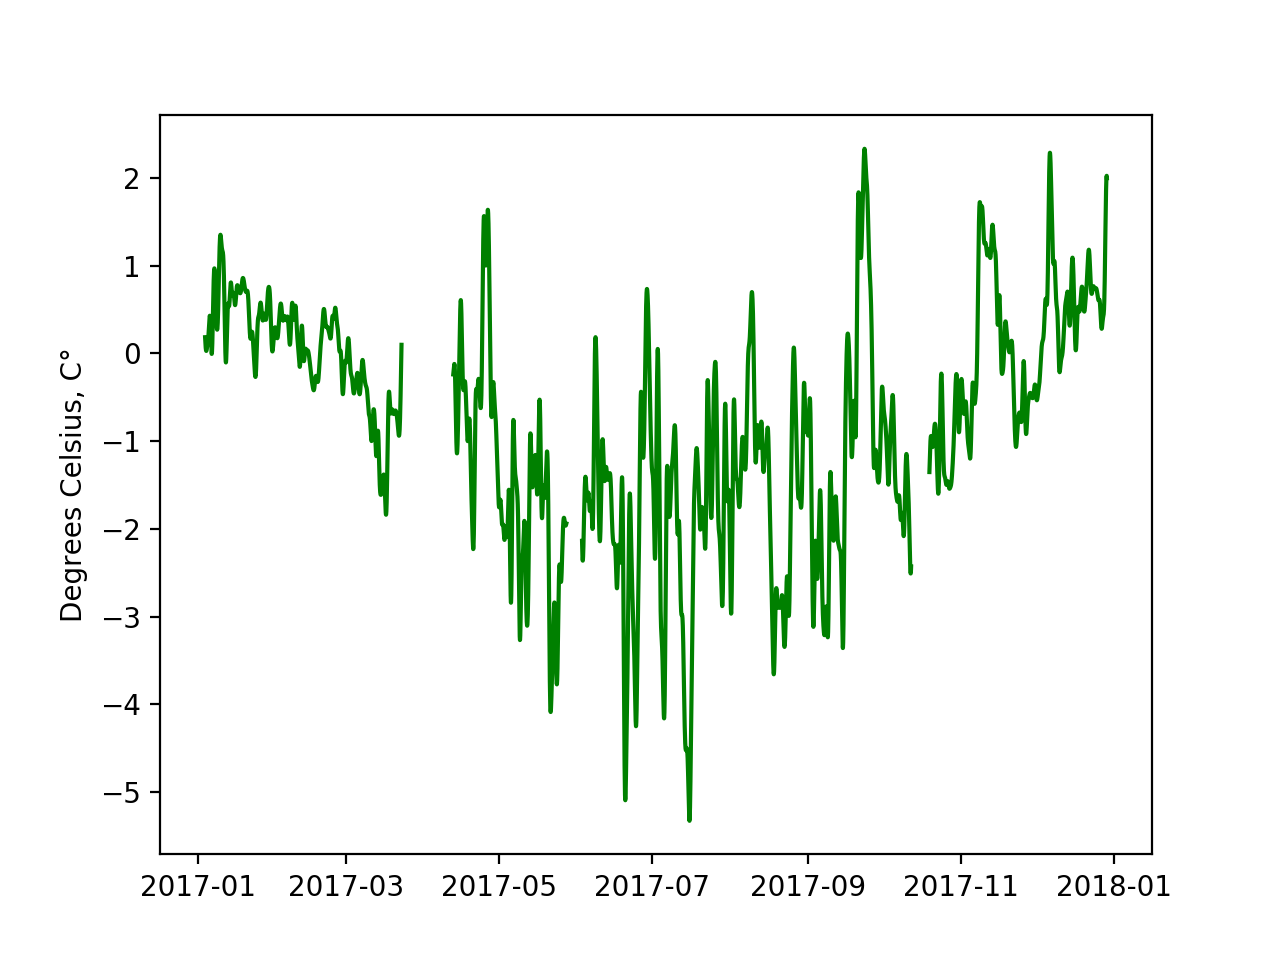

Text(0, 0.5, 'Degrees Celsius, C°')

In [28]:
plt.figure()
plt.plot(sfos_hrly.index,bbos_lfp-sfns_lfp,'g')
plt.ylabel('Degrees Celsius, C°')

<IPython.core.display.Javascript object>


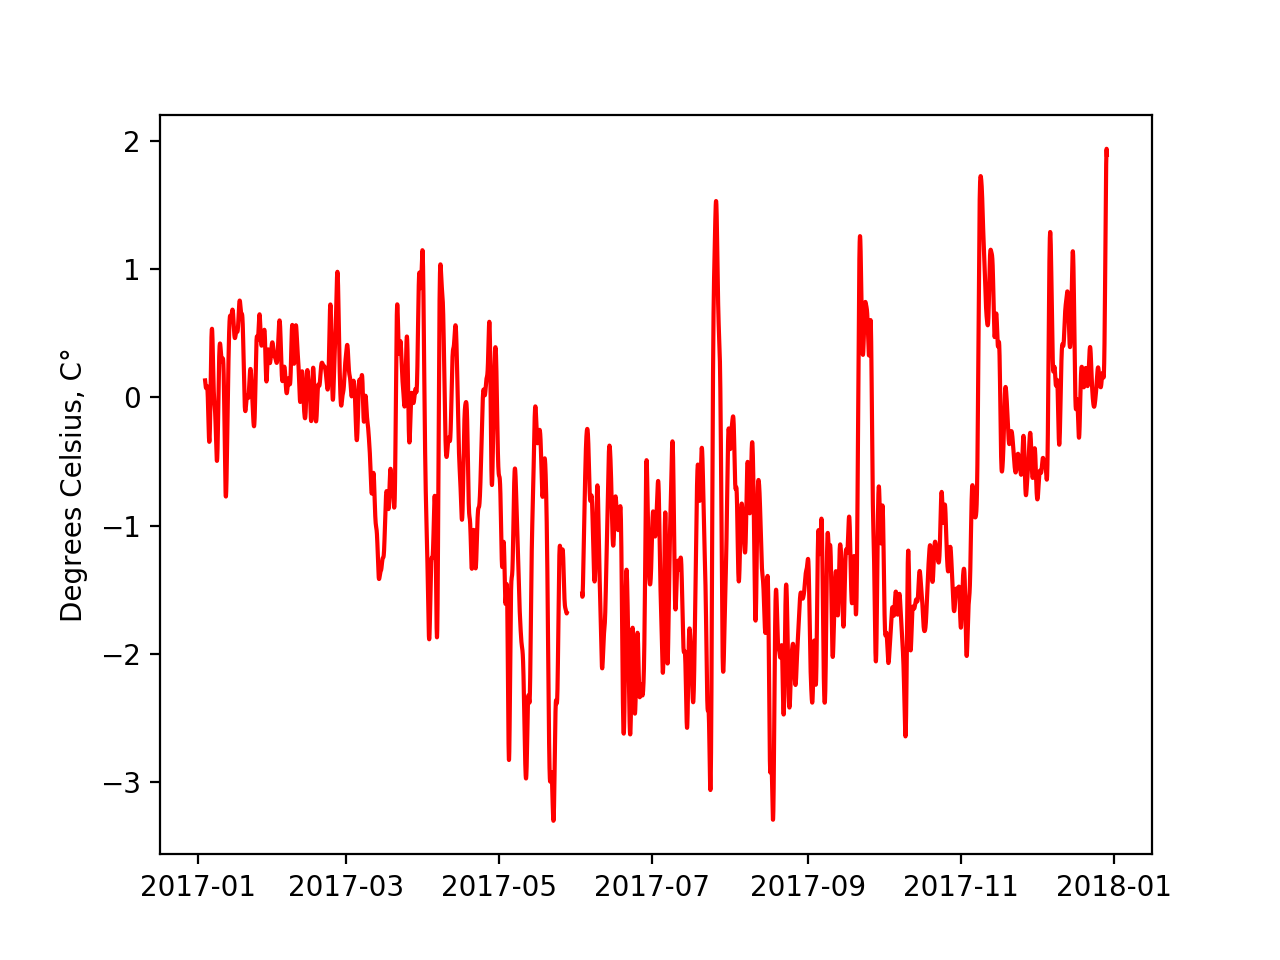

Text(0, 0.5, 'Degrees Celsius, C°')

In [22]:
plt.figure()
plt.plot(sfos_hrly.index,bbos_lfp-sfos_lfp,'r')
plt.ylabel('Degrees Celsius, C°')

In [18]:
plt.figure()
plt.plot(bbos_hrly['degC.1'],sfos_hrly['wtmp'],'r.')

<IPython.core.display.Javascript object>

/anaconda3/lib/python3.7/site-packages/cartopy/io/img_tiles.py:320: UserWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  "The StamenTerrain class was deprecated in v0.17. "


<IPython.core.display.Javascript object>


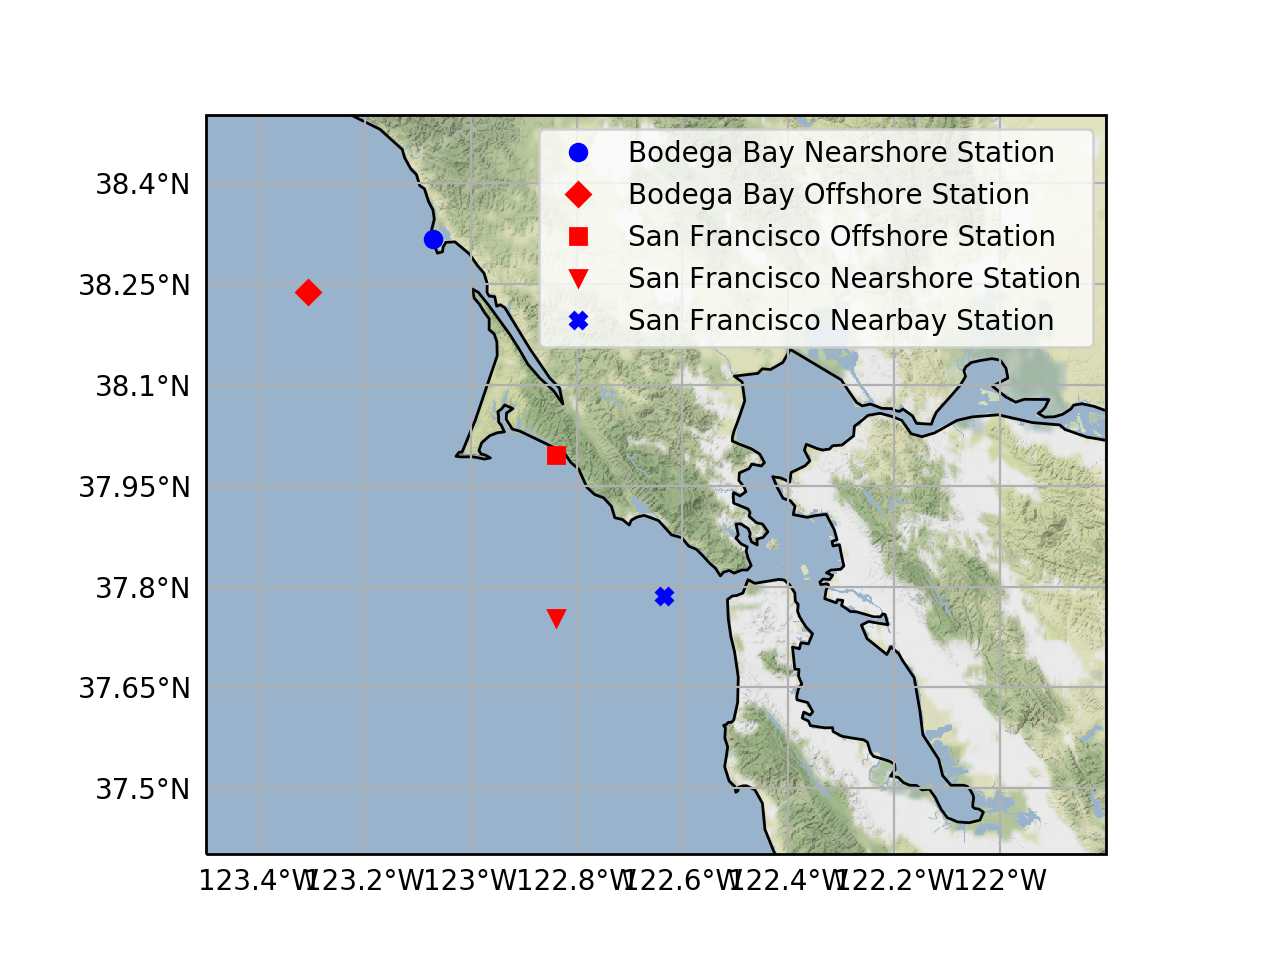

In [23]:
request = cigmt.StamenTerrain()

plt.figure()
ax = make_map(projection=request.crs)
ax.set_extent(GoF)
ax.add_image(request,10)
ax.coastlines('10m')

lat = 38.238, 38.317, 37.996, 37.754, 37.786
lon = -123.307, -123.071, -122.977, -122.839, -122.635

#plt.plot(lon,lat,'md',transform=ccrs.PlateCarree())

bbos_lat = 38.238
bbos_lon = -123.307
bbns_lat = 38.317
bbns_lon = -123.071
sfns_lat = 37.996
sfns_lon = -122.977
sfos_lat = 37.754
sfos_lon = -122.839
sfnb_lat = 37.786
sfnb_lon = -122.635
labels = ['Bodega Bay Nearshore Station','Bodega Bay Offshore Station',
          'San Francisco Offshore Station','San Francisco Nearshore Station'
          ,'San Francisco Nearbay Station']
plt.plot(bbns_lon,bbns_lat,'bo',transform=ccrs.PlateCarree())
plt.plot(bbos_lon,bbos_lat,'rD',transform=ccrs.PlateCarree())
plt.plot(sfos_lon,sfns_lat,'rs',transform=ccrs.PlateCarree())
plt.plot(sfos_lon,sfos_lat,'rv',transform=ccrs.PlateCarree())
plt.plot(sfnb_lon,sfnb_lat,'bX',transform=ccrs.PlateCarree())

plt.legend(labels)

In [36]:
w = sfos_tmp.loc['2017-05-08':'2017-05-22']
x = bbos_tmp.loc['2017-05-08':'2017-05-22']
y = sfns_tmp.loc['2017-05-08':'2017-05-22']
sst1 = stats.ttest_ind(x,w,equal_var=False)
sst2 = stats.ttest_ind(x,y,equal_var=False)
print(sst1)
print(sst2)

Ttest_indResult(statistic=-24.653068891141704, pvalue=6.3639376418736665e-83)
Ttest_indResult(statistic=-34.25876542296056, pvalue=2.4478643920162505e-123)


TypeError: tuple indices must be integers or slices, not tuple